In [1]:
import yfinance as yf
import pywt

import numpy as np
import pandas as pd
import re
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import StratifiedKFold
from pandas.plotting import autocorrelation_plot
from statsmodels.tsa.stattools import adfuller
import talib
from sklearn.metrics import f1_score
import seaborn as sns
import copy
from torch.autograd import grad
from torch.utils.tensorboard import SummaryWriter

# writer = SummaryWriter('runs/port_opt_1')

2024-04-21 11:00:28.335089: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-21 11:00:28.335205: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-21 11:00:28.441999: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-04-21 11:00:28.655294: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-21 11:00:30.161239: W tensorflow/compiler/tf2

In [2]:
# !pip install yfinance


In [2]:
def provide_data(index,start,end,freq):
    data = yf.Ticker(index)
    dat = data.history(interval = freq,start = start,end = end)
    # snp.index = snp.index.map(lambda x: str(x).split(' ')[0])
    dat['return'] = dat['Close'].pct_change().apply(lambda x:100*x)
    dat =dat.dropna()
    return dat

In [3]:
# provide_data('^GSPC','2001-01-01','2023-01-01','1d')

In [4]:
def prepare_data(index):
    start,end,fre = '2001-01-01','2023-01-01','1d'
    # snp = provide_data('RELIANCE.NS',start,end,fre)
    snp = provide_data(index,start,end,fre)
    snp_futures = provide_data('YM=F',start,end,fre)
    def extract_macd(stock_prices):
        macd, macdsignal, macdhist = talib.MACD(stock_prices, fastperiod=12, slowperiod=26, signalperiod=9)
        return macd,macdsignal
    
    res1,res2 = extract_macd(np.array(snp['Close'].values))
    snp['Macd Signal'] = res2
    snp['Macd'] = res1
    # snp['Macd diff'] = res1-res2
    snp['Simple MA'] = talib.SMA(snp['Close'],14)
    snp['EMA'] = talib.EMA(snp['Close'], timeperiod = 14)
    snp['upper_band'], snp['middle_band'], snp['lower_band'] = talib.BBANDS(snp['Close'], timeperiod =20)
    snp['RSI'] = talib.RSI(snp['Close'],14) 
    snp['slowk'], snp['slowd'] = talib.STOCH(snp['High'], snp['Low'], snp['Close'], fastk_period=14, slowk_period=3, slowk_matype=0, slowd_period=3, slowd_matype=0) 
    snp['diff_stoch'] = snp['slowk']-snp['slowd']
    
    # snp[['Close','Simple MA','EMA']][:300].plot(figsize=(15,15)),plt.show()
    # snp[['Macd','Macd Signal']][:300].plot(figsize = (15,15)),plt.show()
    # plt.figure(figsize=(15,15))
    # plt.plot(res1[:300]-res2[:300])
    # plt.show()
    # snp[['Close','upper_band','middle_band','lower_band']][:300].plot(figsize=(15,15)),plt.show()
    # snp['RSI'][:300].plot(figsize=(15,15)),plt.show()
    # snp[['slowk','slowd']][:300].plot(figsize=(15,15)),plt.show()
    
    # snp.to_csv('stock_data.csv')
    
    cut_len = len(snp['Close'])
    for col in snp.columns: 
        nan_indices = np.where(np.isnan(snp[col]))[0]
    #     print(nan_indices)
        # Remove NaN values from the array
        arr_no_nan = np.delete(snp[col], nan_indices)
        cut_len = int(min(cut_len,arr_no_nan.shape[0]))
    cut_len
    
    snp = snp.drop(snp.index[range(len(snp['Close'])-cut_len)])
    # print(snp.index[0],type(snp.index[0]))
    remove_col = ['Volume','Dividends', 'Stock Splits','return']
    col_len = len(snp.columns)-len(remove_col)
    
    snp = snp.drop(columns=remove_col)
    snp
    # autocorrelation_plot(snp['Close'])
    result = adfuller(snp['Close'])
    plt.plot(snp['Close'].values),plt.show()
    print(result)
    
    
    level=1
    data_wt = snp['Close'][:int(pow(2,level))*int(len(snp['Close'])/int(pow(2,level)))]
    cc = pywt.swt(data_wt,'db5',level = level,norm=True)
    print(len(cc[0][1]),len(cc[0][0]),len(cc))
    df = snp.iloc[-len(data_wt)+200:]
    # print(df['Close'])
    snp = df.copy()
    snp['swt0'] = cc[0][0][200:]
    
    # snp['swt1'] = cc[1][0][200:]
    # snp['swt2'] = cc[2][0][200:]
    # snp['swt3'] = cc[3][0][200:]
    # snp['swt4'] = cc[4][0][200:]
    
    snp['hf0'] = cc[0][1][200:]
    
    # snp['hf1'] = cc[1][1][200:]
    # snp['hf2'] = cc[2][1][200:]
    # snp['hf3'] = cc[3][1][200:]
    # snp['hf4'] = cc[4][1][200:]
    # snp['Close'] = cc[0][0][200:]a
    
    # print(snp['Close'],snp['swt'])
    # plt.plot(df['Close'].values),plt.show()
    # plt.plot(snp['Close']),plt.show()
    snp = snp.drop(columns=['Open','High','Low'])
    # print(snp.columns)
    return snp

In [5]:
# prepare_data('IXIC')

In [6]:
t_steps1 = 100
t_steps2 = 10
predict_steps = 1
extra_days = 0
batch_size = 32
pd1 = 0.2
pu1 = 1.2
# pd1 = -1.1
# pd2 = -0.3
# pu1 = 0.2
# pu2 = 0.7
# pu3 = 1.3
classes = 2


In [7]:
# np.savetxt("matrix.txt", np.array2string(, precision=2), delimiter="  ")
# formatter = {'float': lambda x: f'{x:.2f}'}
# print(np.array2string(np.corrcoef([np.array(snp[col].values) for col in snp.columns]), formatter=formatter, suppress_small=True))
def data_transform(data,t_steps):    
    def temp_function(data):
#         return None
        temp_data_list = []
        for i in range(0,len(data)-(t_steps+predict_steps+extra_days)):
            mi,mx = np.min(data[i:i+t_steps]),np.max(data[i:i+t_steps])
            temp_data_list.append((data[i:i+t_steps]-mi)/(mx-mi))
#             temp_data_list.append(data[i:i+t_steps])
        temp_arr = np.array(temp_data_list,dtype = np.float32)
        return temp_arr.reshape(temp_arr.shape[0],temp_arr.shape[1],-1)
    dynamic_feat_list = [temp_function(data[col]) for col in data.columns[:] if col!='Close']
    
#     print(len(dynamic_feat_list))            
    data_C = np.asarray(data['Close'],dtype = np.float32)
    target_data_list = []
    data_pred = []
    labels = []
    pst_arr = []
    for i in range(0,len(data)-(t_steps+predict_steps+extra_days),1):
        data_past = data_C[i:i+t_steps]
#         print(data_C[i+t_steps])
        # pred = np.mean(data_C[i+t_steps+extra_days:i+t_steps+extra_days+predict_steps])
        pred = data_C[i+t_steps+predict_steps-1]
#         print(pred)
        data_pred.append(list([pred]))
        std_past = np.std(data_past)
#         past = np.mean(data_past)
        past = data_past[-1]
        pst_arr.append(past)
#         pst_arr.append(data['swt'][i:i+t_steps][-1])
#         if pred<pd1:
#             id=0
#         elif pred<pd2:
#             id=1
#         elif pred<=pu1:
#             id=2
#         elif pred<pu2:
#             id=3
#         elif pred<=pu3:
#             id=4
#         else:
#             id=5
        if pred<past:
            id=0
        else:
            id=1
        label = np.zeros((classes))
        label[id]=1
        labels.append(label)
        mi,mx = np.min(data_past),np.max(data_past)
        target_data_list.append((data_past-mi)/(mx-mi))
#         target_data_list.append(data_past)
    target_data_arr = np.array(target_data_list,dtype=np.float32)
    target_data_arr = target_data_arr.reshape(target_data_arr.shape[0],target_data_arr.shape[1],-1)
    final_dynamic_feat = np.concatenate(dynamic_feat_list,axis=2)
#     print(final_dynamic_feat)
    final_dataset = np.concatenate((final_dynamic_feat,target_data_arr),axis=2)
    return final_dataset,np.array(data_pred),labels,np.array(pst_arr)

# dat_tf,df_pr,dt_labels,df_past = data_transform(snp,snp_futures,t_steps1)
# print(dat_tf.shape,dat_tf,len(dt_labels),np.count_nonzero(np.isnan(dat_tf)))
# print(input_long.shape)

# cnt = [0]*classes
# for i in dt_labels:
#     for j in range(classes):
#         cnt[j]+=i[j]

# cnt = cnt/sum(cnt)
# # print(dt_labels)
# print(cnt)

In [8]:
class stock_dataset(Dataset):
    def __init__(self,data,t_steps1):
#         print(len(data),len(data2))
        self.dat_long,self.pred_long,self.label_long,self.past_arr = data_transform(data,t_steps1)

#         self.dat_short,self.pred_short,self.label_short = data_transform(data,data2,t_steps2)
    def __len__(self):
        return len(self.dat_long)

    def __getitem__(self, idx):
        
        return self.dat_long[idx][:t_steps1],self.label_long[idx],self.pred_long[idx],self.past_arr[idx]
def prepare_dataloader(train_dataset,test_dataset):

    train_dataloader = DataLoader(train_dataset,batch_size = batch_size,shuffle = True,drop_last = True)
    test_dataloader = DataLoader(test_dataset,batch_size = 1,shuffle = False,drop_last = True)
    
    # print(train_dataset[2],len(snp))
    # print(test_dataset[-1])
    return train_dataloader,test_dataloader

In [9]:
def confusion_mat1():
    y_pred,y_true = [],[]
    with torch.no_grad():
        for i,data in enumerate(test_dataloader):
            inp,labels,pred,past = data[0],data[1],data[2],data[3]
            out = model(inp.repeat(batch_size,1,1))[0]
            temp = [0]*classes
            y_pred.append(torch.argmax(out))
            y_true.append(torch.argmax(labels))
        
        print(len(y_true),len(y_pred))
        print((len(y_pred)-sum([abs(x-y) for x,y in zip(y_true,y_pred)]))/len(y_pred))
        conf_mat = confusion_matrix(y_true,y_pred,normalize='pred')
        print(conf_mat)
        # print(np.trace(np.array(conf_mat))/classes)
        print(f1_score(y_true,y_pred))
def confusion_mat2():
    y_pred,y_true = [],[]
    with torch.no_grad():
        for i,data in enumerate(test_dataloader):
            inp,labels,pred = data[0],data[1],data[2]
            # out = model(inp.repeat(batch_size,1,1))[0]
            encoder_outputs, (hidden, cell) = encoder(inp.repeat(1,1,1))
          # input = trg[:-1]
            out,reg,wts = decoder( hidden, cell, encoder_outputs)
            temp = [0]*classes
#             temp[torch.argmax(out)]=1
            y_pred.append(torch.argmax(out))
            y_true.append(torch.argmax(labels))
            if i%100==0:
                # print(wts)
                sns.heatmap(wts[0])
                plt.show()
        y_true,y_pred = np.array(y_true),np.array(y_pred)

        print(len(y_true),len(y_pred))
        print((len(y_pred)-sum([abs(x-y) for x,y in zip(y_true,y_pred)]))/len(y_pred))
        conf_mat = confusion_matrix(y_true,y_pred,normalize='pred')
        print(conf_mat)
        # print(np.trace(np.array(conf_mat))/classes)
        print(f1_score(y_true,y_pred))
        
class stock_lstm2(torch.nn.Module):
    def __init__(self,input_dim,output_dim,batch_size,t_steps1,t_steps2,classes):
        super(stock_lstm,self).__init__()
        self.batch_size = batch_size
        self.in_dim = input_dim
        self.out_dim = output_dim
        self.nlayers = 6

        self.lstm1 = nn.LSTM(input_size = input_dim,hidden_size = output_dim,num_layers = self.nlayers,batch_first = True)
        self.lstm2 = nn.LSTM(input_size = input_dim,hidden_size = output_dim,num_layers = self.nlayers,batch_first = True)

        self.ln_long = nn.LayerNorm((t_steps1,self.in_dim))
        self.ln_short = nn.LayerNorm((t_steps2,self.in_dim))

        self.tanh = nn.Tanh()
        self.dropout = nn.Dropout(0.2)
        self.sig = nn.Sigmoid()
        self.soft = nn.Softmax()

        self.fc1_long = nn.Linear(t_steps*self.in_dim,t_steps*self.in_dim//2)
        self.fc2_long = nn.Linear(t_steps*self.in_dim//2,classes)
        self.fc1_short = nn.Linear(t_steps2*self.in_dim,t_steps2*self.in_dim//2)
        self.fc2_short = nn.Linear(t_steps2*self.in_dim//2,classes)
        self.fc3 = nn.Linear(2*classes,classes)

    def forward(self,input_long,input_short):
        input_long = input_long.view(self.batch_size,-1,self.in_dim)
        input_short = input_short.view(self.batch_size,-1,self.in_dim)
        h_0_long = input_long[:][:,0].view(1,self.batch_size,-1).repeat(self.nlayers,1,1)
        h_0_short = input_short[:][:,0].view(1,self.batch_size,-1).repeat(self.nlayers,1,1)
        input_long = self.ln_long(input_long)
        input_short = self.ln_short(input_short)

#         lstm_out,_ = self.lstm1(input_series,(h_0,torch.zeros(h_0.shape)))
        lstm_long,_ = self.lstm1(input_long)
        lstm_long = self.ln_long(lstm_long)
        lstm_long = self.tanh(lstm_long)
        lstm_long = lstm_long.view(self.batch_size,-1)

        lstm_short,_ = self.lstm1(input_short)
        lstm_short = self.ln_short(lstm_short)
        lstm_short = self.tanh(lstm_short)
        lstm_short = lstm_short.view(self.batch_size,-1)

        out_long = self.fc1_long(lstm_long)
        out_long = self.sig(out_long)
        out_long = self.fc2_long(out_long)
        out_long = self.soft(out_long)

        out_short = self.fc1(lstm_short)
        out_short = self.sig(out_short)
        out_short = self.fc2(out_short)
        out_short = self.soft(out_short)

        out = self.fc3(np.hstack(out_long,out_short))
        out = self.soft(out)
#         print(input_series[0],lstm_out[0],out_pre[0])
#         out_final = self.act2(out_pre)
#         out_final = self.fc2(out_pre)
        return out
class stock_lstm(torch.nn.Module):
    def __init__(self,input_dim,d_model,n_layers,batch_size,t_steps,classes):
        super(stock_lstm,self).__init__()
        self.batch_size = batch_size
        self.in_dim = input_dim
        self.d_model = d_model
        self.nlayers = n_layers

        self.lstm1 = nn.LSTM(input_size = input_dim,hidden_size = d_model,num_layers = self.nlayers,batch_first = True)

        # self.input_ln = nn.LayerNorm((t_steps,self.in_dim))
        self.lstm_ln = nn.LayerNorm((t_steps,self.d_model))

        self.tanh = nn.Tanh()
        self.dropout = nn.Dropout(0.5)
        self.sig = nn.Sigmoid()
        self.soft = nn.Softmax()

        self.fc1_long = nn.Linear(t_steps*self.d_model,t_steps*self.d_model//2)
        self.fc2_long = nn.Linear(t_steps*self.d_model//2,t_steps*self.d_model//4)
        self.fc3_long = nn.Linear(t_steps*self.d_model//4,classes)

    def forward(self,input_long):
#         print(input_long.shape,input_long[0])
#         input_long = np.transpose(input_long,(0,2,1))
#         h_0_long = input_long[:][:,0].view(1,self.batch_size,-1).repeat(self.nlayers,1,1)
#         input_long = self.input_ln(input_long)
#         print(torch.mean(input_long,dim=(1,2)))
        lstm_long,_ = self.lstm1(input_long)
        lstm_long = self.lstm_ln(lstm_long)
        lstm_long = self.tanh(lstm_long)
        lstm_long = lstm_long.reshape(lstm_long.shape[0],-1)

        out_long = self.fc1_long(lstm_long)
        out_long = self.sig(out_long)
        out_long = self.fc2_long(out_long)
        # out_long = self.soft(out_long)
        out_long = self.sig(out_long)
        out_long = self.fc3_long(out_long)
        out  = self.soft(out_long)

        return out
class Encoder(nn.Module):
    def __init__(self, input_dim, hid_dim, n_layers, t_steps):
        super().__init__()
        self.d_model = hid_dim
        self.t_steps= t_steps
        self.input_dim = input_dim
        self.nlayers = n_layers
        self.rnn = nn.LSTM(input_dim, hid_dim, n_layers, dropout=0.5,batch_first = True)
        self.rnncell = nn.LSTMCell(input_dim,hid_dim)
#         self.rnn2 = nn.LSTM(input_dim,hid_dim,n_layers,dropout=0.2,batch_first=True)
        self.ln = nn.LayerNorm((t_steps,input_dim))
        self.lno = nn.LayerNorm((t_steps,hid_dim))
        self.Q = nn.Linear(hid_dim,hid_dim)
        self.K = nn.Linear(hid_dim,hid_dim)
        self.Q2 = nn.Linear(input_dim,input_dim)
        self.K2 = nn.Linear(hid_dim,input_dim)
        self.relu = nn.ReLU()
        self.tanh = nn.Tanh()
        self.lrelu = nn.LeakyReLU()
        self.sig = nn.Sigmoid()
    def feature_attn(self,inp,h):
        inp = inp[:,None,:]
        h = h[:,None,:]
        Q2 = inp
        K2 = self.K2(h)
        
        wts = F.softmax(torch.matmul(torch.transpose(Q2,1,2),K2),dim=-1)
#         print(Q2.shape,K2.shape,wts.shape)
        out = torch.matmul(inp,wts.transpose(1,2))
        out = out[:,0,:]
#         print(out.shape)
        return out,wts
    def attn(self,Q,K):
        # Q = self.Q(Qs)
        # K = self.K(Ks)
        wts = F.softmax(torch.matmul(Q,torch.transpose(K,1,2)),dim=-1)
        output = torch.matmul(wts,Q)
        return output,wts
        
    def forward(self, src):
        # inp_mi = torch.tensor(torch.min(src,dim=1)[0])[:,None,:]
        # inp_mx = torch.tensor(torch.max(src,dim=1)[0])[:,None,:]
        # src = (src -inp_mi)/(inp_mx-inp_mi)
        # src = self.ln(src)
#         h0 = np.sum(src[:,0,:],axis=)
        
#         h0 = torch.zeros((src.shape[0],self.d_model))
#         c0=torch.zeros((src.shape[0],self.d_model))
#         output = []
#         # cells = []
#         for i in range(self.t_steps):
#             inp = src[:,i,:]
#             inp,wtsf = self.feature_attn(inp,h0)
# #             inp = self.ln(inp)
#             h0,c0 = self.rnncell(inp,(h0,c0))
#             h0,c0 = self.relu(h0),self.relu(c0)
# #             print(h0.shape)
#             output.append(h0)
#             # cells.append(c0)
#         output = torch.stack(output,dim=1)
#         # cells = torch.stack(cells,dim=1)
#         output,wts = self.attn(output,output)
#         output = self.lno(output)
#         # cells,wts = self.attn(cells,output)
#         hidden,cell = output[:,-1,:],c0
        # return outputs,(hidden, cell),wtsf
        
#         hidden,cell = h0[:,None,:],c0[:,None,:]


        # Q2 = self.Q2(src)
        # K2 = self.K2(src)
        # wts2 = F.softmax(torch.matmul(torch.transpose(Q2,1,2),K2),dim=-1)
        # src2 = torch.matmul(wts2,src.transpose(1,2)).transpose(1,2)
        # src2 = feature_attn(src,)
        # src2 = self.ln(src2)
        outputs, (hidden, cell) = self.rnn(src)
        outputs = self.tanh(outputs)
        hidden = hidden.transpose(0,1)
        cell = cell.transpose(0,1)
        hidden = hidden[:,0,:]
        cell = cell[:,0,:]
        # Q = self.Q(outputs)
        # K = self.K(outputs)
        # wts = F.softmax(torch.matmul(Q,torch.transpose(K,1,2)),dim=-1)
        # output = torch.matmul(wts,outputs)

#         print(output.shape,wts.shape,hidden.shape)
        return outputs,(hidden, cell)


class Decoder(nn.Module):
    def __init__(self, output_dim,hid_dim, n_layers, p_steps,t_steps):
        super().__init__()
        # self.embedding = nn.Embedding(output_dim, emb_dim)
        self.psteps = p_steps
#         self.rnn = nn.LSTM(hid_dim , hid_dim, n_layers, dropout=0.5)
        self.ln = nn.LayerNorm((t_steps,hid_dim))
        self.rnncell = nn.LSTMCell(hid_dim,hid_dim)
        self.out = nn.Linear(hid_dim, output_dim)
        self.Qc = nn.Linear(hid_dim,hid_dim)
        self.Kc = nn.Linear(hid_dim,hid_dim)
        self.Qs = nn.Linear(hid_dim,hid_dim)
        self.Ks = nn.Linear(hid_dim,hid_dim)
        # self.fc1 = nn.Linear(n_layers*hid_dim,hid_dim)
        self.fc1 = nn.Linear(hid_dim,output_dim)
        self.sig = nn.Sigmoid()
        self.soft = nn.Softmax()
        self.logsoft = nn.LogSoftmax()
        self.relu = nn.ReLU()
        self.lrelu = nn.LeakyReLU()
        self.tanh = nn.Tanh()
        self.fc2 = nn.Linear(hid_dim,hid_dim//2)
        self.fc3 = nn.Linear(hid_dim//2,output_dim)
        self.rfc = nn.Linear(hid_dim,hid_dim//2)
        self.rfc2 = nn.Linear(hid_dim//2,hid_dim//4)
        self.rfc3 = nn.Linear(hid_dim//4,1)
    def cross_attn(self,Qs,Ks):
        if len(Ks.shape)<3:
            Ks = Ks[:,None,:]
        Q = Qs
        K = Ks
        wts = F.softmax(torch.matmul(Q,torch.transpose(K,1,2)),dim=-2)
        output = torch.matmul(wts.transpose(1,2),Qs)
        output = output[:,0,:]
        return output,wts
    def self_attn(self,Qs,Ks):
        if len(Ks.shape)<3:
            Ks = Ks[:,None,:]
        Q = Qs
        K = Ks
        wts = F.softmax(torch.matmul(Q,torch.transpose(K,1,2)),dim=-2)
        output = torch.matmul(wts.transpose(1,2),Qs)
        output = output[:,0,:]
        return output,wts
    def forward(self, hidden, cell, encoder_outputs):
        # print(encoder_outputs.shape,hidden.transpose(1,0).shape)
        # query = self.Q(encoder_outputs.reshape(encoder_outputs.shape[0],-1))
        # query = query.reshape(query.shape[0],-1,query.shape[1]).transpose(2,1)
        # query = query.transpose(2,1)
#         hidden = hidden.transpose(1,0)
#         scores = torch.matmul(hidden,query)
#         attention_weights = torch.softmax(scores,dim=1)
#         value = torch.mul(hidden,attention_weights)
#         out = self.fc1(value.reshape(value.shape[0],-1))
#         prediction = self.soft(out)
#         print(encoder_outputs.shape,hidden.transpose(1,0).shape)
#         encoder_outputs = self.Q(encoder_outputs)
#         scores = torch.matmul(hidden.transpose(1,0),encoder_outputs.transpose(2,1))
#         attention_weights = torch.softmax(scores,dim=-1)
# #         print(scores.shape,attention_weights.shape,attention_weights)
#         value = torch.matmul(attention_weights,encoder_outputs)
#         value = self.V(value)
#         value = value.reshape(value.shape[0],-1)
#         out = self.sig(value)
#         out = self.fc1(out)
#         out = self.sig(out)
#         out = self.fc2(out)
#         prediction = self.soft(out)

        
        encoder_outputs = encoder_outputs
        h0,c0 = hidden,cell
        a1,wts = self.cross_attn(encoder_outputs,h0)
        
        # h0 = h0[:,0,:]
        # c0 = c0[:,0,:]
        # print(h0.shape)
        h0,c0 = self.rnncell(h0,(a1,c0))
        h0,c0 = self.tanh(h0),self.tanh(c0)
        hiddens = h0[:,None,:]
        for i in range(self.psteps-1):
            a1,_ = self.cross_attn(encoder_outputs,h0)
            a2,_ = self.cross_attn(hiddens,h0)
            h0,c0 = self.rnncell(h0,(a1+a2,c0))
            h0,c0 = self.relu(h0),self.relu(c0)
            hiddens = torch.cat((hiddens,h0[:,None,:]),1)
        out = self.fc1(h0)
        # out = self.sig(out)
        # out = self.fc2(out)
        # out = self.sig(out)
        # out = self.fc3(out)
        prediction = self.soft(out)
        reg = self.rfc(h0)
        reg = self.sig(reg)
        reg = self.rfc2(reg)
        reg = self.sig(reg)
        reg = self.rfc3(reg)
        reg = self.tanh(reg)
        
        return prediction,reg,wts

In [10]:
t_steps1 = 20
predict_steps = 1
batch_size = 64
classes = 2
stock = '^IRX'

# import gspc_train_20_5.pt
def fetch(stock,split,t_steps,p_steps):
    file = '{}_{}_{}_{}.pt'.format(stock,split,t_steps,p_steps)
    return torch.load(file)
def prepare_task(stock,t_steps1,predict_steps,classes):
    try:
        nme = re.sub(r'[^a-zA-Z]', '', stock).lower()
        train_dataset = fetch(nme,'train',t_steps1,predict_steps)
        test_dataset = fetch(nme,'test',t_steps1,predict_steps)
        
    except:
        print('file not found . starting to prepare')
        index = prepare_data(stock)
        train_len = int(0.85*len(index))
        test_len = len(index)-train_len
        
        train_dataset = stock_dataset(index[:train_len],t_steps1)
        test_dataset = stock_dataset(index[-(len(index)-train_len):],t_steps1)
        nme = re.sub(r'[^a-zA-Z]', '', stock).lower()
        torch.save(train_dataset,'./{}_train_{}_{}.pt'.format(nme,t_steps1,predict_steps))
        torch.save(test_dataset,'./{}_test_{}_{}.pt'.format(nme,t_steps1,predict_steps))
    in_dim = train_dataset.dat_long.shape[2]
    out_dim = in_dim
    cnt = [0]*classes
    for i in train_dataset.label_long:
        for j in range(classes):
            cnt[j]+=i[j]
    cnt/=sum(cnt)
    print(cnt,'cnt')
    
    train_dataloader,test_dataloader = prepare_dataloader(train_dataset,test_dataset)
    return train_dataloader,test_dataloader,cnt
# print(cnt)
# confusion_mat2()
# confusion_mat1()

file not found . starting to prepare


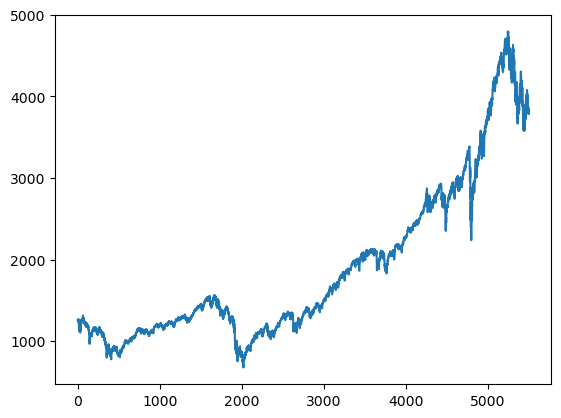

(0.32851090080687073, 0.9786153954937146, 27, 5473, {'1%': -3.4315453900435435, '5%': -2.8620682431852114, '10%': -2.56705118276025}, 50508.99996352711)
5500 5500 1
[0.45896521 0.54103479] cnt
file not found . starting to prepare


^IRX: No price data found, symbol may be delisted (1d 2001-01-01 -> 2023-01-01)


In [11]:
task1 = prepare_task('^GSPC',t_steps1,predict_steps,classes)
task2 = prepare_task('^IRX',t_steps1,predict_steps,classes)
task3 = prepare_task('^IXIC',t_steps1,predict_steps,classes)
task4 = prepare_task('DJI',t_steps1,predict_steps,classes)
task5 = prepare_task('CL=F',t_steps1,predict_steps,classes)
in_dim = task1[0].dataset.dat_long.shape[2]
out_dim=in_dim

In [13]:
# in_dim

In [15]:

n_layers = 2
d_model = 32
encoder = Encoder(in_dim, d_model, n_layers,t_steps1)
decoder = Decoder(classes, d_model, n_layers, predict_steps,t_steps1)

# Define the optimizer and criterion




In [16]:
# %reload_ext tensorboard
# dataiter = iter(train_dataloader)
# src,trg,pred,past = next(dataiter)
# print(src,src.shape)
# out,(hid,cel) = encoder(src)
# writer.add_graph(encoder,src)
# writer.add_graph(decoder,(hid,cel,out))
# writer.close()
# writer.flush()
 
# %tensorboard --logdir=runs
# next(iter(task1[0]))
# for k,p in model.named_parameters():
#     print(k)

In [13]:
n_layers = 2
d_model = 16
model = stock_lstm(in_dim,d_model,n_layers,batch_size,t_steps1,classes)
optimizer = torch.optim.Adam(model.parameters())

In [20]:
# chkpt = torch.load('stock_lstm_meta_12345_0shots.pt')
# model.load_state_dict(chkpt['state_dict'])

In [15]:
# def diffout():
def model_test(test_dataloader,model):
    y_pred,y_true = [],[]
    for i,test_data in enumerate(test_dataloader):
        src=test_data[0]
        trg = test_data[1]
        pred=test_data[2][:,0]
        past=test_data[3]
        output = model(src)
#         if i%50==0:
#             print(criterion1(output,trg))
        y_pred.append(torch.argmax(output))
        y_true.append(torch.argmax(trg))
    print(f1_score(y_true,y_pred))
    
def meta_test(model,task_list,n_shots=0):
    
    for task in task_list:
        criterion1 = nn.CrossEntropyLoss(weight = torch.tensor(task[2]))
        tmodel = copy.deepcopy(model)
        optimizer = torch.optim.Adam(tmodel.parameters())
        test_dataloader =  task[1]
        itr = iter(test_dataloader)
        for _ in range(n_shots):
            test_data = next(itr)
            src=test_data[0]
            trg = test_data[1]
            pred=test_data[2][:,0]
            past=test_data[3]
            output = tmodel(src)
            loss = criterion1(output,trg)
            loss.backward()
            optimizer.step()
        tmodel.eval()
        model_test(test_dataloader,tmodel)


def meta_train(epochs,task_list,n_shots=0):
    loss_list = []
    criterion = nn.CrossEntropyLoss()
    # optimizer = torch.optim.Adam(list(encoder.parameters()) + list(decoder.parameters()))
    # optimizer = torch.optim.Adam(model.parameters())
    # criterion1 = nn.NLLLoss(weight=torch.tensor(cnt))
    # criterion2 = nn.MSELoss()
    matches,length = 0,0
    inner_lr = 0.01
    meta_lr=0.001
    for epoch in tqdm(range(epochs)):
        grads = []
        for task in task_list:
            
            train_dataloader = task[0]
            criterion1 = nn.CrossEntropyLoss(weight = torch.tensor(task[2]))
            itr = iter(train_dataloader)
            fmodel = stock_lstm(in_dim,d_model,n_layers,batch_size,t_steps1,classes)
            fmodel.load_state_dict(model.state_dict())
            fast_wts = dict((name,param) for (name,param) in fmodel.named_parameters())
            loss=0
            # print('fast_wts',fast_wts[0])
            for _ in range(n_shots):
                print('ho gaya')
                train_data = next(itr)
                src = train_data[0]
                trg = train_data[1]
                pred = train_data[2][:,0]
                past = train_data[3]
                
                # encoder_outputs, (hidden, cell) = fenc(src)
                # output,reg,wts = fdec( hidden, cell, encoder_outputs)
                output = fmodel(src)
                # reg = reg[:,0]
                ls = criterion1(output,trg)
                gd = grad(ls,fmodel.parameters())
                # foptimizer.step()
                fast_wts = dict((name, param - inner_lr * g) for ((name, param), g) in zip(fast_wts.items(), gd))
                fmodel.load_state_dict(fast_wts)

            # iid=0
            # print(len(fast_wts))
            # for i,p in enumerate(fmodel.parameters()):
            #     p=fast_wts[i]
            #     # sz = np.prod(list(p.shape))
            #     # # print(iid,sz)
            #     # print('fast weights',fast_wts[iid:iid+sz])
            #     # p.data = torch.tensor(fast_wts[iid:iid+sz]).view_as(p)
            #     # iid+=sz
            for i,train_data in enumerate(train_dataloader):
                src = train_data[0]
                # print(i,src[0].shape,src[0])
                # break
                trg = train_data[1]
                pred = train_data[2][:,0]
                past = train_data[3]
                # optimizer.zero_grad()
                # encoder_outputs, (hidden, cell) = encoder(src)
    
                # # input = trg[:-1]
                # output,reg,wts = decoder( hidden, cell, encoder_outputs)
                # reg = reg[:,0]
                output = fmodel(src)
                
                loss += criterion1(output, trg)/len(task_list)
                # print(grad(loss,model.parameters(),retain_graph=True,allow_unused=True))
                # 'kn;
                # break
                # print(reg.shape)
                # l2 = criterion2(pred,past*reg)/(batch_size*pow(10,torch.log10(past[-1])))
                # loss = l2+l1
                # loss = l1
                
                # length+=batch_size
                if i%8000==0:
                    # print(epoch,l2,"out >>>> ",output[:1],"\nlabel >>>> ",train_data[1][:1])
                    # print(epoch,loss,past[-1],past[-1]*(1+reg[-1]),l2,output[:1],train_data[1][:1],l1)
                    print(loss,output.shape,trg.shape,output[0,:],'>>>>>>>>>>>>>>>>.',trg[0,:])
                    # if epoch%20==0:
                    #     sns.heatmap(wts[0].detach().numpy())
                    #     plt.show()
            g = torch.autograd.grad(loss, fmodel.parameters(), create_graph=True)
            meta_grads = {name:g for ((name, _), g) in zip(fmodel.named_parameters(), g)}
            grads.append(meta_grads)
                # loss_list.append(loss.detach().numpy())
        output = model(src)
        loss = criterion(output,trg)
        loss.backward(retain_graph=True)
        # print(grads)
        gradients = {k: sum(d[k] for d in grads) for k in grads[0].keys()}
        hooks = []
        for(k,v) in model.named_parameters():
            def get_closure():
                key = k
                def replace_grad(grad):
                    return gradients[key]
                return replace_grad
            hooks.append(v.register_hook(get_closure()))
        torch.optim.Adam(model.parameters(), lr=meta_lr).zero_grad()
        loss.backward()

        torch.optim.Adam(model.parameters(), lr=meta_lr).step()

        # Remove the hooks before next training phase
        for h in hooks:
            h.remove()
    for task in task_list:
        test_dataloader = task[1]
        for i,test_data in enumerate(test_dataloader):
            src=test_data[0]
            trg = test_data[1]
            pred=test_data[2][:,0]
            past=test_data[3]
            # encoder_outputs, (hidden, cell) = encoder(src)

            # # input = trg[:-1]
            # output,reg,wts = decoder( hidden, cell, encoder_outputs)
            output = model(src)
            if i%50==0:
                print(criterion1(output,trg))
            # optimizer.zero_grad()
                
    #             break
    # print('train_acc = ',matches/length)
    return loss_list
n_shots = 0
task_list = [task1,task2,task3,task4,task5]
# loss_list = meta_train(500,task_list,n_shots=n_shots)
# confusion_mat2()
# writer.flush()

In [ ]:
torch.save({'state_dict':model.state_dict()},'stock_lstm_meta_12345_shots.pt')

In [1]:
chkpt = torch.load('/kaggle/working/stock_lstm_meta_1234_1shots.pt')
model.load_state_dict(chkpt['state_dict'])

NameError: name 'torch' is not defined

In [26]:
meta_test(model,task_list,1)

/opt/conda/lib/python3.10/site-packages/torch/nn/modules/module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


0.8289611752360966


/opt/conda/lib/python3.10/site-packages/torch/nn/modules/module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


0.6054644808743169


/opt/conda/lib/python3.10/site-packages/torch/nn/modules/module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


0.8380355276907002


/opt/conda/lib/python3.10/site-packages/torch/nn/modules/module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


0.8327796234772978


In [59]:
for task in task_list:
    y_pred,y_true = [],[]
    test_dataloader = task[1]
    for i,test_data in enumerate(test_dataloader):
        src=test_data[0]
        trg = test_data[1]
        pred=test_data[2][:,0]
        past=test_data[3]
        output = model(src)
#         if i%50==0:
#             print(criterion1(output,trg))
        y_pred.append(torch.argmax(output))
        y_true.append(torch.argmax(trg))
    print(f1_score(y_true,y_pred))


/opt/conda/lib/python3.10/site-packages/torch/nn/modules/module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


0.7211961301671065


/opt/conda/lib/python3.10/site-packages/torch/nn/modules/module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


0.7347972972972971


/opt/conda/lib/python3.10/site-packages/torch/nn/modules/module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


0.7425569176882661


/opt/conda/lib/python3.10/site-packages/torch/nn/modules/module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


0.7226415094339623


In [ ]:

def train2(epochs):
    loss_list = []
    criterion1 = nn.CrossEntropyLoss(weight=torch.tensor(cnt))
    optimizer = torch.optim.Adam(list(encoder.parameters()) + list(decoder.parameters()))
    # criterion1 = nn.NLLLoss(weight=torch.tensor(cnt))
    criterion2 = nn.MSELoss()
    matches,length = 0,0
    for epoch in range(epochs):
        for i,train_data in enumerate(train_dataloader):
            src = train_data[0]
            trg = train_data[1]
            pred = train_data[2][:,0]
            past = train_data[3]
            optimizer.zero_grad()
            encoder_outputs, (hidden, cell) = encoder(src)

            # input = trg[:-1]
            output,reg,wts = decoder( hidden, cell, encoder_outputs)
            reg = reg[:,0]
            # output_dim = output.shape[-1]
            # output = output.view(-1, output_dim)
            # trg = trg[1:].view(-1)
            
            # print(output.shape,trg.shape,pred.shape,past.shape,reg.shape)
            # print(trg)
            # trg = torch.argmax(trg,dim=1).float()
            # trg = trg.float()
            # print(trg[0],type(trg[0].float()))
            l1 = criterion1(output, trg)
            # print(reg.shape)
            l2 = criterion2(pred,past*reg)/(batch_size*pow(10,torch.log10(past[-1])))
            loss = l2+l1
            # writer.add_scalar("Loss1/train", l1, i+epoch*len(train_dataloader))
            # writer.add_scalar("Loss2/train", l2, i+epoch*len(train_dataloader))
            # matches+=batch_size-sum(np.argmax(output.detach().numpy(),axis=1)-np.argmax(trg.numpy(),axis=1))
            length+=batch_size
            if i%8000==0:
                # print(epoch,l2,"out >>>> ",output[:1],"\nlabel >>>> ",train_data[1][:1])
                print(epoch,loss,past[-1],past[-1]*(1+reg[-1]),l2,output[:1],train_data[1][:1],l1)
                if epoch%20==0:
                    sns.heatmap(wts[0].detach().numpy())
                    plt.show()


            loss_list.append(loss.detach().numpy())
            loss.backward()
            optimizer.step()
#             break
    print('train_acc = ',matches/length)
    return loss_list
loss_list = train2(200)
confusion_mat2()
# writer.flush()

In [ ]:
plt.plot(loss_list[-20000:])
# torch.save({
#             'enc_state_dict': encoder.state_dict(),
#             'dec_state_dict': decoder.state_dict(),
#             'optimizer_state_dict': optimizer.state_dict(),


#             }, 'stock_classifier_enc_dec.pt')

In [ ]:
n_layers = 2
d_model = 16
model = stock_lstm(in_dim,d_model,n_layers,batch_size,t_steps1,classes)
optimizer = torch.optim.Adam(model.parameters())
# criterion = nn.CrossEntropyLoss()
# try:
#     checkpoint = torch.load('stock_classifier_lstm.pt')
#     model.load_state_dict(checkpoint['model_state_dict'])
#     optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
# except:
#     pass

In [16]:
loss_list = []


def train(epochs,tsk):
    matches,length = 0,0
    train_dataloader = tsk[0]
    criterion = nn.CrossEntropyLoss(weight = torch.tensor(tsk[2]))
    for epoch in range(epochs):
        for i,train_data in enumerate(train_dataloader):
            model.zero_grad()
#             in_mean = torch.mean(train_data[0],dim=1,keepdim=True)
#             in_std = torch.std(train_data[0],dim=1,keepdim=True)
            inp,exp_out = train_data[0],train_data[1]
#             print(exp_out)
#             return
            out = model(inp)
            loss = criterion(out,exp_out)
            matches+=batch_size-sum(np.argmax(out.detach().numpy(),axis=1)-np.argmax(exp_out.numpy(),axis=1))
            length+=batch_size
#             return
            if i%8000==0:
#                 model()
                print(epoch,loss,"out >>>> ",out[:1],"\nlabel >>>> ",train_data[1][:1])
#                 break
#                 return
            
            loss_list.append(loss.detach().numpy())
            loss.backward()
            optimizer.step()
    print('train_acc = ',matches/length)
for tsk in task_list:
    train(200,tsk)
# confusion_mat1()
# torch.save({
#             'model_state_dict': model.state_dict(),
#             'optimizer_state_dict': optimizer.state_dict(),

            
#             }, 'stock_classifier_lstm.pt')

/home/siddhss20/anaconda3/envs/nlp/lib/python3.10/site-packages/torch/nn/modules/module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


0 tensor(0.3419, dtype=torch.float64, grad_fn=<DivBackward1>) out >>>>  tensor([[0.4107, 0.5893]], grad_fn=<SliceBackward0>) 
label >>>>  tensor([[1., 0.]], dtype=torch.float64)
1 tensor(0.3537, dtype=torch.float64, grad_fn=<DivBackward1>) out >>>>  tensor([[0.2912, 0.7088]], grad_fn=<SliceBackward0>) 
label >>>>  tensor([[1., 0.]], dtype=torch.float64)
2 tensor(0.3332, dtype=torch.float64, grad_fn=<DivBackward1>) out >>>>  tensor([[0.3349, 0.6651]], grad_fn=<SliceBackward0>) 
label >>>>  tensor([[0., 1.]], dtype=torch.float64)
3 tensor(0.3459, dtype=torch.float64, grad_fn=<DivBackward1>) out >>>>  tensor([[0.3528, 0.6472]], grad_fn=<SliceBackward0>) 
label >>>>  tensor([[0., 1.]], dtype=torch.float64)
4 tensor(0.3470, dtype=torch.float64, grad_fn=<DivBackward1>) out >>>>  tensor([[0.3611, 0.6389]], grad_fn=<SliceBackward0>) 
label >>>>  tensor([[0., 1.]], dtype=torch.float64)
5 tensor(0.3435, dtype=torch.float64, grad_fn=<DivBackward1>) out >>>>  tensor([[0.3035, 0.6965]], grad_fn=<Sl

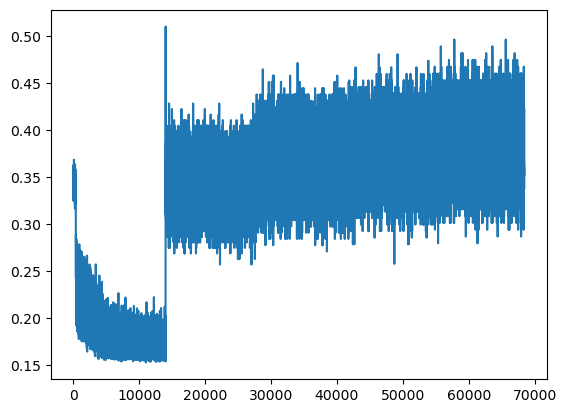

In [17]:
plt.plot(loss_list)

In [21]:
def model_test(test_dataloader,model):
    y_pred,y_true = [],[]
    for i,test_data in enumerate(test_dataloader):
        src=test_data[0]
        trg = test_data[1]
        pred=test_data[2][:,0]
        past=test_data[3]
        output = model(src)
#         if i%50==0:
#             print(criterion1(output,trg))
        y_pred.append(torch.argmax(output))
        y_true.append(torch.argmax(trg))
    print(f1_score(y_true,y_pred))
    
def meta_test(model,task_list,n_shots=0):
    
    for task in task_list:
        criterion1 = nn.CrossEntropyLoss(weight = torch.tensor(task[2]))
        tmodel = copy.deepcopy(model)
        optimizer = torch.optim.Adam(tmodel.parameters())
        test_dataloader =  task[1]
        itr = iter(test_dataloader)
        for _ in range(n_shots):
            test_data = next(itr)
            src=test_data[0]
            trg = test_data[1]
            pred=test_data[2][:,0]
            past=test_data[3]
            output = tmodel(src)
            loss = criterion1(output,trg)
            loss.backward()
            optimizer.step()
        tmodel.eval()
        model_test(test_dataloader,tmodel)
meta_test(model,task_list,0)

/home/siddhss20/anaconda3/envs/nlp/lib/python3.10/site-packages/torch/nn/modules/module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


0.6925675675675677


/home/siddhss20/anaconda3/envs/nlp/lib/python3.10/site-packages/torch/nn/modules/module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


0.7424857839155159


/home/siddhss20/anaconda3/envs/nlp/lib/python3.10/site-packages/torch/nn/modules/module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


0.7078464106844742


/home/siddhss20/anaconda3/envs/nlp/lib/python3.10/site-packages/torch/nn/modules/module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


0.6963636363636364


/home/siddhss20/anaconda3/envs/nlp/lib/python3.10/site-packages/torch/nn/modules/module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


0.714879467996675


In [ ]:


def test1(t_steps,i1=0,i2=1e9):
    colr = ['red','green']
#     print()
    i2 = int(min(i2,test_len-t_steps-extra_days))
#     plt.plot(range(i1,i2),snp['Close'][train_len+i1+t_steps:train_len+i2+t_steps],color ='black',linewidth=0.5)
    with torch.no_grad():
        for i,data in enumerate(test_dataloader):
            if(i<i1 or i>i2):
                continue
            inp,labels,pred,past = data[0],data[1],data[2],data[3]
#             print(pred)
            out = model(inp.repeat(batch_size,1,1))[0]
#             print(inp[0,:,-1][-1])
#             past,std_past = torch.mean(inp[0,:,-1][-1]),torch.std(inp[0,:,-1])
            idx = torch.argmax(out)
#             print(idx)
#             return
            plt.scatter(i,past,color='black',s=2,alpha=0.3)
#             plt.scatter(i,snp['swt'][i+train_len+t_steps1-1],color='blue',s=2,alpha=0.5)
            if(idx==0):
                plt.fill_between(
                    range(i,i+predict_steps),
                    past-(10*pd1)*np.sqrt(past), 
                    past, 
                    alpha=0.5,
                    color=colr[idx],
                    interpolate=True,
                    label="+/- 1-std",
                )
            if(idx==1):
                plt.fill_between(
                    range(i,i+predict_steps),
                    past, 
                    past+5*pu1*np.sqrt(past), 
                    alpha=0.5,
                    color=colr[idx],
                    interpolate=True,
                    label="+/- 1-std",
                )
            if(idx==2):
                plt.fill_between(
                    range(i,i+predict_steps),
                    past+pu1*std_past, 
                    past+2*pu1*std_past, 
                    alpha=0.5,
                    color=colr[idx],
                    interpolate=True,
                    label="+/- 1-std",
                )
#             if(idx==3):
#                 plt.fill_between(
#                     range(i,i+predict_steps),
#                     past+par_k2*par_k*std_past, 
#                     past+(par_k2+1)*par_k*std_past, 
#                     alpha=0.5,
#                     color=colr[idx],
#                     interpolate=True,
#                     label="+/- 1-std",
#                 )
#             if(i==200):
#                 break
def random_confusion():
    y_pred,y_true = [],[]
    colr = ['red','green']
    for i,data in enumerate(test_dataloader):
        inp,labels,_,past = data[0],data[1],data[2],data[3]
        # out = model(inp.repeat(batch_size,1,1))[0]
      # input = trg[:-1]
#         past,std_past = torch.mean(inp[0,:,-1]),torch.std(inp[0,:,-1])
#         past,std_past = torch.mean(inp[0,:,-1][-1]),torch.std(inp[0,:,-1])
        pred = snp['swt'][i+train_len+t_steps1-1]
        if pred<past:
            idx=0
        else:
            idx=1
        pred_label = torch.tensor(idx)
#         pred_label[id]=1
        y_pred.append(pred_label)
#             temp[torch.argmax(out)]=1
        y_true.append(torch.argmax(labels))
    conf_mat = confusion_matrix(y_true,y_pred,normalize='pred')
    print(conf_mat)
    print(np.trace(np.array(conf_mat))/classes)
    
def random_confusion_return():
    y_pred,y_true = [],[]
    for i,data in enumerate(test_dataloader):
        inp,labels,pred = data[0],data[1],data[2]
        # out = model(inp.repeat(batch_size,1,1))[0]
      # input = trg[:-1]
#         past = talib.EMA(inp[0,:,-1].numpy().astype(np.float64),timeperiod = len(inp[0,:,-1]))[-1]
        past = torch.mean(inp[0,:,-1][-3:])
        pred = 100*(torch.mean(inp[0,:,-1][-1])-past)/past
        
        if pred<pd1:
            id=0
        elif pred<pd2:
            id=1
        elif pred<=pu1:
            id=2
        elif pred<pu2:
            id=3
        elif pred<=pu3:
            id=4
        else:
            id=5
        pred_label = torch.tensor(np.random.randint(0,6,1))[0]
#         pred_label = torch.tensor(id)
#         print(pred_label)
#         pred_label[id]=1
        y_pred.append(pred_label)
#             temp[torch.argmax(out)]=1
        y_true.append(torch.argmax(labels))
#         y_true,y_pred = np.array(y_true),np.array(y_pred)

#     print(y_true,y_pred)
    conf_mat = confusion_matrix(y_true,y_pred,normalize='pred')
    print(conf_mat)
    print(np.trace(np.array(conf_mat))/classes)

def test2(t_steps,i1=0,i2=1e9):
    colr = ['red','green']
#     colr = ['darkred','indianred','orange','yellowgreen','lime','darkgreen']
#     print()
    i2 = int(min(i2,test_len-t_steps-extra_days))
    profit = 0
    g_cnt = 0
    toler = 0.75
    ry_cnt = 0
    gy_cnt = 0
    r_cnt = 0
    investment = 0
#     prev_trade = 0
    list_trade = []
    cnt_trade = 0
    profit_trade = 0
    prev = -1
    entry = 0
    plt.figure(figsize=(15,15))
#     plt.plot(range(i1,i2),snp['Close'][train_len+i1+t_steps-1+extra_days:train_len+i2+t_steps-1+extra_days],color ='black',linewidth=0.5)
    with torch.no_grad():
        for i,data in enumerate(test_dataloader):
            if(i<i1 or i>i2):
                continue
            inp,labels,pred,past = data[0],data[1],data[2],data[3]
            encoder_outputs, (hidden, cell) = encoder(inp.repeat(batch_size,1,1))
            out = decoder( hidden, cell, encoder_outputs)[0]
            
            plt.scatter(i,past,color='black',s=2,alpha=0.3)
#             plt.scatter(i,snp['swt'][i+train_len+t_steps1-1],color='blue',s=2,alpha=0.5)
            print(past)
            idx = torch.argmax(out)

            if(idx==0):
                plt.fill_between(
                    range(i,i+predict_steps),
                    past-(10*pd1)*np.sqrt(past), 
                    past, 
                    alpha=0.5,
                    color=colr[idx],
                    interpolate=True,
                    label="+/- 1-std",
                )
            if(idx==1):
                plt.fill_between(
                    range(i,i+predict_steps),
                    past, 
                    past+5*pu1*np.sqrt(past), 
                    alpha=0.5,
                    color=colr[idx],
                    interpolate=True,
                    label="+/- 1-std",
                )
            if(idx==2):
                plt.fill_between(
                    range(i,i+predict_steps),
                    past+pu1*std_past, 
                    past+2*pu1*std_past, 
                    alpha=0.5,
                    color=colr[idx],
                    interpolate=True,
                    label="+/- 1-std",
                )
#             if(idx==0):
#                 plt.fill_between(
#                     range(i,i+predict_steps),
#                     past*(1+2*pd1),
#                     past*(1+pd1),
#                     alpha=0.8,
#                     color=colr[idx],
#                     interpolate=True,
#                     label="+/- 1-std",
#                 )
#             if(idx==1):
#                 plt.fill_between(
#                     range(i,i+predict_steps),
#                     past*(1+pd1),
#                     past*(1+pd2),
#                     alpha=0.8,
#                     color=colr[idx],
#                     interpolate=True,
#                     label="+/- 1-std",
#                 )
#             if(idx==2):
#                 plt.fill_between(
#                     range(i,i+predict_steps),
#                     past*(1+pd2),
#                     past*(1+pu1),
#                     alpha=0.8,
#                     color=colr[idx],
#                     interpolate=True,
#                     label="+/- 1-std",
#                 )
#             if(idx==3):
#                 plt.fill_between(
#                     range(i,i+predict_steps),
#                     past*(1+pu1),
#                     past*(1+pu2),
#                     alpha=0.8,
#                     color=colr[idx],
#                     interpolate=True,
#                     label="+/- 1-std",
#                 )
#             if(idx==4):
#                 plt.fill_between(
#                     range(i,i+predict_steps),
#                     past*(1+pu2),
#                     past*(1+pu3),
#                     alpha=0.8,
#                     color=colr[idx],
#                     interpolate=True,
#                     label="+/- 1-std",
#                 )
#             if(idx==5):
#                 plt.fill_between(
#                     range(i,i+predict_steps),
#                     past*(1+pu3),
#                     past*(1+pu3*2),
#                     alpha=0.8,
#                     color=colr[idx],
#                     interpolate=True,
#                     label="+/- 1-std",
#                 )
            prev=idx
# test2(t_steps1,700,1200)
confusion_mat2()
# random_confusion()
confusion_mat1()
